In [ ]:
# @title Install components
# for running Ollama in Google colab
!sudo apt-get install zstd
!curl https://ollama.ai/install.sh | sh
!pip install ollama

!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections
!sudo apt-get update && sudo apt-get install -y cuda-drivers

import os
# Set LD_LIBRARY_PATH so the system NVIDIA library
os.environ.update({'LD_LIBRARY_PATH': '/usr/lib64-nvidia'})

In [ ]:
# @title Start server
import subprocess
proccess = subprocess.Popen(['ollama', 'serve'])

In [ ]:
# @title Install urban-worm
%pip install urban-worm --upgrade

In [1]:
# @title Import package
from urbanworm.inference import llama
from urbanworm.dataset import GeoTaggedData

14 buildings found in the bounding box.


<Axes: >

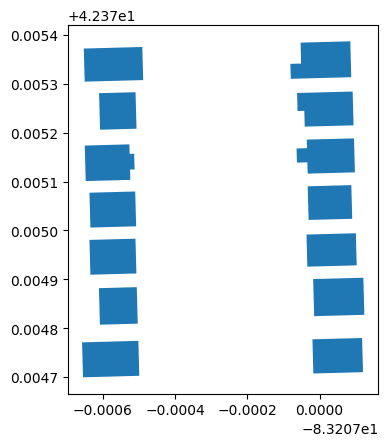

In [3]:
# @title Get building footprints from OSM
# Initiate the constructor
gtd = GeoTaggedData()
# Define the area of interest using a bounding box (bbox)
bbox = (-83.208003,42.374646,-83.206608,42.375328) # in Detroit, USA
# we can just get house with no more than 200 square meter (single family houses with garage excluded)
gtd.getBuildings(bbox, min_area=60, max_area=200)
gtd.units.plot()

In [4]:
# @title Retrieve street views and pass the dataset to inference constructor
key = '' # @param {"type":"string"}
distance = 30 # @param {"type":"integer"}
pano = True # @param ["False", "True"] {type:"raw"}
reoriented = True  # @param ["False", "True"] {type:"raw"}
multi_num = 3  # @param ["False", "True"] {type:"integer"}
fov = 80  # @param {type:"slider", min:50, max:100, step:1}
interval = 2  # @param {"type":"integer"}
start_year = 2024  # @param {"type":"integer"}
end_year = 2025  # @param {"type":"integer"}
time_of_day = 'day'  # @param ['day', 'night']

gtd.get_svi_from_locations(key = key, # Mapillary api key
                           distance = distance,       # only search for available street view with 30 meters from the house location
                           pano = pano,         # only search for 360-degree street view images
                           reoriented = reoriented,   # reorient and crop the street view images to make them only frame the house at the center of scene
                           multi_num = multi_num,       # return three closest street views from the house location
                           fov = fov,            # The field of view in degrees for the reoriented images
                           interval = interval,        # The interval between each street view (i.g, `interval = 2` means there should be two available images between two collected images)
                           year = (start_year, end_year), # only search for images captured between 2024 and 2025
                           time_of_day = time_of_day  # only search for images captured during the daytime
                           )

# indicate that the street view images wil be used
gtd.set_images('svi')
# pass the dataset to the inference constructor
data = llama.InferenceOllama(geo_tagged_data=gtd)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# @title input model repo
model = 'hf.co/ggml-org/InternVL3-8B-Instruct-GGUF:Q8_0' # @param {"type":"string"}
data.llm = model

In [5]:
# @title Define schema
from typing import Literal
data.schema = {
    "answer": (Literal['occupied', 'unoccupied'], ...),
    "explanation": (str, ...),
}

In [ ]:
# @title Set prompt and run inference
prompt = '''
    Question: Does this house look occupied if it is not a vacant lot?

    **An occupied house means that the house is not abandoned and
    some people may live in this house even if there is not people outside**
''' # @param {"type":"string"}

data.batch_inference(prompt=prompt)